In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

C:\Users\APC\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
train_2016 = pd.read_csv('./../preprocessed data/df_train_2016.csv')
predict_2016 = pd.read_csv('./../preprocessed data/df_predict_2016.csv')

train_2017 = pd.read_csv('./../preprocessed data/df_train_2017.csv')
predict_2017 = pd.read_csv('./../preprocessed data/df_predict_2017.csv')

sample = pd.read_csv("./../data/sample_submission.csv")

In [59]:
def standardize(df):
    numerical_columns = ['bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft','latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        Q2 = df[col].quantile(0.5)
        if Q3>Q1:
            df[col] = (df[col]-Q2)/(Q3-Q1)
    return df

In [159]:
def polynomial( X): 
        for var in ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']: 
            # New var names 
            s2_var_name = var + '-s2'
            s3_var_name = var + '-s3'
            sq_var_name = var + '-sqrt'
            
            # Create features 
            X[s2_var_name] = X[var] ** 2 
            X[s3_var_name] = X[var] ** 3 
            X[sq_var_name] = np.sqrt(X[var] )  # Translate feature to ensure min value is 0 before sqrt 
            
        return X

In [131]:
def outliner_drop(df):
    Q1 = df['logerror'].quantile(0.25)
    Q3 = df['logerror'].quantile(0.75)
    IQR = Q3-Q1
    lower_lim = Q1 - 1.5*IQR
    upper_lim = Q3 + 1.5*IQR
    df=df[df.logerror >= lower_lim ]
    df=df[df.logerror <= upper_lim ]
    return df

# 2016 

In [78]:
numerical_columns = ['logerror','bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
corr = train_2016[numerical_columns].corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Index(['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt',
       'structuretaxvaluedollarcnt', 'age', 'poolcnt', 'garagetotalsqft',
       'fireplacecnt'],
      dtype='object')

In [177]:
train_16 = train_2016.copy()
# train_16 = outliner_drop(train_16)
train_16 = polynomial(train_16)
train_16 = standardize(train_16)
y = train_16['logerror']
train_16 = train_16.drop(['logerror'],axis=1)

predict_16 = predict_2016.drop(['parcelid'],axis=1)
predict_16 = polynomial(predict_16)
predict_16 = standardize(predict_16)

In [178]:
X_train, X_test, y_train, y_test = train_test_split(train_16, y, test_size=0.25, shuffle=False)
rlr = Ridge()
rlr.fit(X_train, y_train)

y_pred=rlr.predict(X_test)
df_y=abs(y_test-y_pred)
MAE=df_y.sum()/len(y)
print(MAE)

0.01670512482820633


C:\Users\APC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.66995e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [167]:
# Set of alpha values to test
alphas = np.logspace(1,2)
#alphas = np.arange(28800000,28810000,100)
print(f"Testing with alphas={alphas}")

# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(train_16, y)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[ 10.          10.48113134  10.98541142  11.51395399  12.06792641
  12.64855217  13.25711366  13.89495494  14.56348478  15.26417967
  15.9985872   16.76832937  17.57510625  18.42069969  19.30697729
  20.23589648  21.20950888  22.22996483  23.29951811  24.42053095
  25.59547923  26.82695795  28.11768698  29.47051703  30.88843596
  32.37457543  33.93221772  35.56480306  37.2759372   39.06939937
  40.94915062  42.9193426   44.98432669  47.14866363  49.41713361
  51.79474679  54.28675439  56.89866029  59.63623317  62.50551925
  65.51285569  68.6648845   71.9685673   75.43120063  79.06043211
  82.86427729  86.85113738  91.0298178   95.40954763 100.        ]
Best Ridge Alpha: 71.96856730011521


In [168]:
rlr = Ridge(alpha=ridgecv.alpha_)
rlr.fit(train_16, y)

y_pred=rlr.predict(train_16)
df_y=abs(y-y_pred)
MAE=df_y.sum()/len(y)
print(MAE)

0.035294476136914374


C:\Users\APC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.0485e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [169]:
Y = rlr.predict(predict_16)
sample['201610'] = Y
sample['201611'] = Y
sample['201612'] = Y

# 2017

In [103]:
numerical_columns = ['logerror','bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
corr = train_2017[numerical_columns].corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Index(['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt',
       'garagetotalsqft', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt',
       'structuretaxvaluedollarcnt'],
      dtype='object')

In [170]:
train_17 = train_2017.copy()
train_17 = outliner_drop(train_17)
train_17 = polynomial(train_17)
train_17 = standardize(train_17)
y = train_17['logerror']
train_17 = train_17.drop(['logerror'],axis=1)

predict_17 = predict_2017.drop(['parcelid'],axis=1)
predict_17 = polynomial(predict_17)
predict_17 = standardize(predict_17)

In [172]:
# Set of alpha values to test
alphas = np.logspace(0,2)
#alphas = np.arange(28800000,28810000,100)
print(f"Testing with alphas={alphas}")

# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(train_17, y)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[  1.           1.09854114   1.20679264   1.32571137   1.45634848
   1.59985872   1.75751062   1.93069773   2.12095089   2.32995181
   2.55954792   2.8117687    3.0888436    3.39322177   3.72759372
   4.09491506   4.49843267   4.94171336   5.42867544   5.96362332
   6.55128557   7.19685673   7.90604321   8.68511374   9.54095476
  10.48113134  11.51395399  12.64855217  13.89495494  15.26417967
  16.76832937  18.42069969  20.23589648  22.22996483  24.42053095
  26.82695795  29.47051703  32.37457543  35.56480306  39.06939937
  42.9193426   47.14866363  51.79474679  56.89866029  62.50551925
  68.6648845   75.43120063  82.86427729  91.0298178  100.        ]
Best Ridge Alpha: 4.094915062380425


In [173]:
rlr = Ridge(alpha=ridgecv.alpha_)
rlr.fit(train_17, y)

y_pred=rlr.predict(train_17)
df_y=abs(y-y_pred)
MAE=df_y.sum()/len(y)
print(MAE)

0.034728250026171824


C:\Users\APC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.10057e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [174]:
Y = rlr.predict(predict_17)
sample['201710'] = Y
sample['201711'] = Y
sample['201712'] = Y

In [175]:
sample.to_csv('./../submission/ridge.csv', index=False, float_format='%.4f')

<AxesSubplot:>

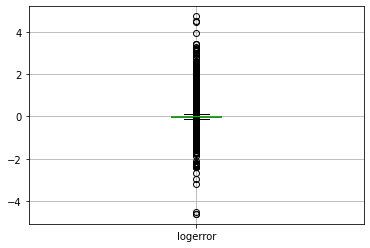

In [48]:
train_2016.boxplot(column=['logerror'])  

<AxesSubplot:xlabel='bathroomcnt'>

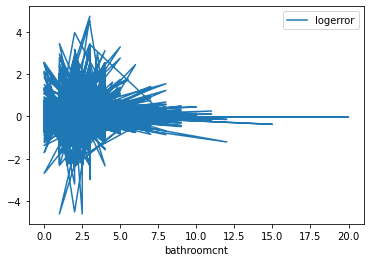

In [143]:
train_2016.plot(x='bathroomcnt', y= 'logerror')

<AxesSubplot:xlabel='bathroomcnt'>

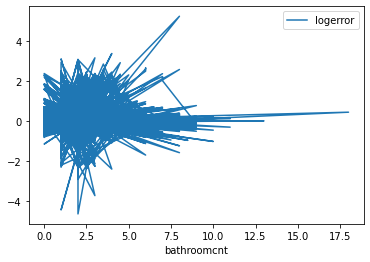

In [144]:
train_2017.plot(x='bathroomcnt', y= 'logerror')